In [1]:
import os 
import numpy as np 
import pandas as pd
import sys
from typing import Dict 
import matplotlib.pyplot as plt 
import openpyxl
import pickle
import tensorflow as tf
sys.path.append("..")

from libreview_utils import *
from models.training import *
from sensor_params import *
from utils import get_LibreView_CGM_X_Y_multistep

from models.multi_step.unet1D import get_model as get_original_unet1D
from models.multi_step.unet1D_dec import get_model as get_unet1D_decoder
from models.multi_step.unet1D_DIL_regressor import get_model as get_DIL_unet1D_multi_step
from models.multi_step.StackedLSTM import get_model as get_StackedLSTM_multi_step

from evaluation.multi_step.evaluation import model_evaluation as multi_step_model_evaluation


# Dataset path 
DATASET_PATH = r"C:\Users\aralmeida\Downloads\LibreViewRawData"

# Parameters 
sensor = libreview_sensors
N = 144
step = 1
verbose = 0
PH = 60

epochs = 10
batch_size = 1
lr=0.0001
model_name = 'original-1DUNET'
loss_function = 'root_mean_squared_error'
loss_function = 'ISO_loss'

normalization = None


# Extract an EXACT 1 year recordings from the dictionary and store them to load them separately 
get_oldest_year_npys_from_LibreView_csv(DATASET_PATH)


Number of patients with at least one year of CGM data:  29


In [2]:
def get_LibreView_CGM_X_Y_UNET_output(recordings : np.array, timestamps : np.array, glucose_sensor : Dict,
                                    N: int, step: int, prediction_horizon : int, plot : bool,
                                    verbose = int) -> Tuple[np.array, np.array, np.array, np.array]:
    """It is the same as get_CGM_X_Y_multistep, but taking as input np.arrays.
    Its name comes from the fact that it was developed to read data from 
    LibreView sensors, but should work for any recording-timestamps peer. 
    Generates the X and Y vectors to train and test a Deep Learning model for CGM 
    forecasting. Suports sequence-to-sequence data generation.Also returns the 
    associated timestamps (as datetime objects).

    Args:
    -----
        recordings (np.array): CGM readings (mg/dL)
        timestamps (np.array) : timestamps associated to each CGM sample (datetime format)
        glucose_sensor (Dict) : Dictionary containing the information of the sensor (including the sample period)
        N (int): window size of the instances in the generated dataset
        step (int): step forward to create the next instance of the dataset
        prediction_horizon (int): prediction horizon in minutes
        plot (bool): if True, plots the sample difference between two consecutive samples
        verbose (int): Verbosity level.
    
    Returns:
    --------
        X (np.ndarray): 2D array with the windows of the CGM readings. Its shape
        is (number of windows, N).
        Y (np.ndarray): 2D array with the sequence just after the end of the correspondant input
        (Value Nth+1). Its shape is (prediction_horizon/sampling frequency of the sensor, 1).
        X_times (np.array): datetime datatypes associated to X 
        Y_times (np.array): datetime datatypes associated to Y
    """ 

    # Compute the differentce between two consecutive samples (in minutes)
    time_diff = np.diff(timestamps)

    # Empty array to fill with the values in minutes 
    time_diff_mins = np.empty(len(time_diff))

    for i in range(0, len(time_diff_mins)): 
        time_diff_mins[i] = (time_diff[i].seconds)//60 

    # Plot all time intervals between two consecutive samples
    if plot == True: 
        # Set IEEE style
        #plt.style.use(['science', 'ieee'])
        plt.figure()

        # Plot 
        plt.plot(time_diff_mins)

        # Horizontal line in 30 (2 consecutive samples)
        plt.axhline(y=glucose_sensor["SAMPLE_PERIOD"]*2, color='r', linestyle='-')

        # Set X label
        plt.xlabel('Sample difference')

        # Set Y label
        plt.ylabel('Minutes between sensor readings')

        # Save figure
        plt.savefig('sample_difference.png', dpi=300, bbox_inches='tight')

    # Find indexes where the difference between two consecutive samples is greater than 10 minutes
    time_diff_idx = np.where(time_diff_mins > glucose_sensor["SAMPLE_PERIOD"]*2)

    # Number of blocks in a patient are defined when two consecutive readings surpass 2*sensor["SAMPLE_PERIOD"]
    n_blocks = len(time_diff_mins[np.where(time_diff_mins > glucose_sensor["SAMPLE_PERIOD"]*2)])
    print("Number of blocks of is %i\n" % (n_blocks))

    # Step for the output value identification - 1: For N = 49, the output is 5 min (value 50) / 2: 10 min (value 51) / etc. 
    step = round(prediction_horizon/glucose_sensor["SAMPLE_PERIOD"])

    # Global index useful to extract the blocks for the original array
    global_idx = 0 # 1 in matlab

    # Numpy array to count samples in each block
    num_samples = np.zeros((n_blocks, 1))

    # List to store the indexes X and Y (faster computation than concatenate arrays)
    X_init_list = []
    X_end_list = []
    Y_init_list = []
    Y_end_list = []

    for i in range(0, n_blocks):
    
        # Compute size of the current block
        block_size = time_diff_idx[0][i]-global_idx
        
        if verbose == 1:
            print("Block size is %i" % (block_size))
        
        # Loop until the last value possible value of the block considering N
        for j in range(0, round(block_size - N - step)):

            # Reference value for the initial data point to be collected 
            X_init_list.append(global_idx+j)

            # Reference value for the last data point to be collected 
            X_end_list.append(global_idx+j+N)

            # Reference value for the initial Y point to be collected 
            Y_init_list.append(global_idx+j+step)

            # Reference value for the last data point to be collected 
            Y_end_list.append(global_idx+j+step+N)

            # Count the samples of the current block
            num_samples[i] = j+1

        # Print number of samples 
        if verbose == 1:
            print("Number of samples in block %i is %i\n" % ((i+1), num_samples[i]))

        # Update the global index
        global_idx = time_diff_idx[0][i] 

    # Declare X an Y vector with all time and glucose concatenated data to further processing
    X = np.zeros((len(X_init_list), N), dtype=np.float32)
    Y = np.zeros((len(Y_init_list), N), dtype=np.float32) # Check values on sensor_params.py and arch_params.py
    X_times = np.empty((len(X_init_list), N), dtype='datetime64[s]')
    Y_times = np.empty((len(Y_init_list), N), dtype='datetime64[s]')

    for i in range(0, X.shape[0]):
        X[i,:] = recordings[X_init_list[i] : X_end_list[i]]
        Y[i,:] = recordings[Y_init_list[i] : Y_end_list[i]]
        X_times[i,:] = timestamps[X_init_list[i] : X_end_list[i]]
        Y_times[i] = timestamps[Y_init_list[i] : Y_end_list[i]] 

    # Save training dataset summary in a txt file
    with open('dataset_summary.txt', 'w') as f:
        f.write('N = {}\n'.format(N))
        f.write('step = {}\n'.format(step))
        f.write('PH = {}\n'.format(prediction_horizon))
        f.write('sensor = {}\n'.format(glucose_sensor['NAME']))
        f.write('nº blocks = {}\n'.format(n_blocks))

    # Export X, Y and associated times as .npy files
    np.save('X.npy', X)
    np.save('Y.npy', Y)
    np.save('X_times.npy', X_times)
    np.save('Y_times.npy', Y_times) 

    # Convert np.arrays to float32 to convert them to Tensorflow tensors
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)

    return X, Y, X_times, Y_times


In [3]:
def weighted_mse(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Custom loss function adapted from the classic RMSE to force the model 
    to have a larger amount of  CGM prediction points within the ISO [1] and
    Parker [2] ranges.

    Args: 
    -----
        y_true: The true glucose values.
        y_pred: The predicted glucose values.
        n : orden del comportamiento exponencial del termino de confinamiento ("filtro"). Fuera de la region de interes Default : 40.
        admisible_gamma : aportacion de de termino de confinamiento (ke2n) en la region de interes. Default : 0.1.   
        upper_bound_error : limite superior en la region de interes. Default : 14.
    
    Returns:
    --------
        loss: The loss value.

    References:
    -----------
        [1] ISO
        [2] Parker

    """

    # Tensor of shape y_true full of 0.5
    weights = tf.ones_like(y_true) * 0.5

    # Place in the last four points a weight of 1
    weights[:, -4:] = 1

    # Compute the MSE
    mse = tf.keras.losses.MSE(y_true, y_pred)

    # Compute the weighted MSE
    w_mse = mse * weights

    return w_mse

PATIENT : 001
Number of blocks of is 180

X shape:  (13100, 144)
Y shape:  (13100, 4) 

~~~~~~~~~~~~~~~~~~
Running training using  GPU: ['device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:09:00.0, compute capability: 8.9']
Epoch 1/10
10480/10480 [==============================] - 345s 32ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195 - ISO_adapted_loss: 0.0143
Epoch 2/10
10480/10480 [==============================] - 316s 30ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - ISO_adapted_loss: 0.0060
Epoch 3/10
10480/10480 [==============================] - 340s 32ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683 - ISO_adapted_loss: 0.0047
Epoch 4/10
10480/10480 [==============================] - 341s 33ms/step - loss: 0.0044 - root_mean_squared_error: 0.0665 - ISO_adapted_loss: 0.0044
Epoch 5/10
10480/10480 [==============================] - 331s 32ms/step - loss: 0.0043 - root_mean_squared_error: 0.0658 - ISO_adapted_loss: 0.0043
Epoch 6/10
10480/104

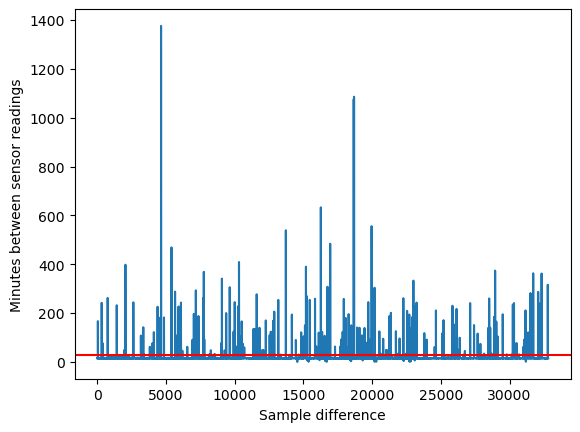

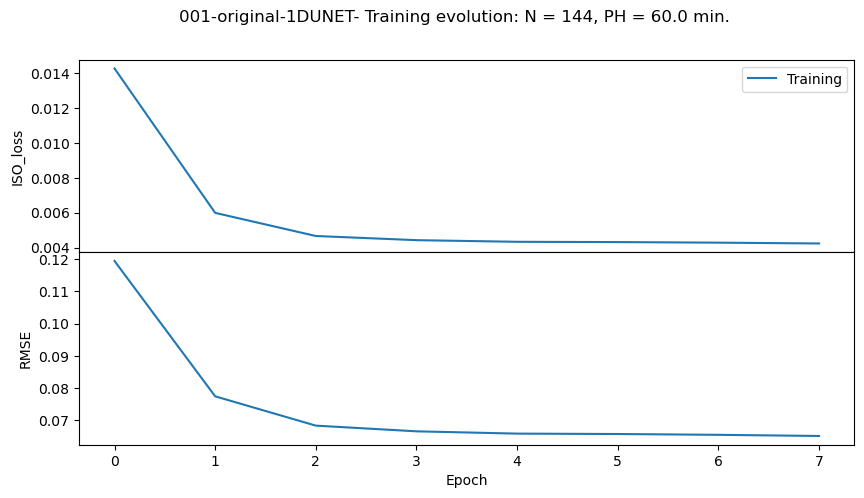

In [4]:
ids = ['001']
# Iterate over the ID folders to generate the 4-folds 
for id in ids: 
#for id in os.listdir(): 
    
    # Consider only folders, not .npy or .txt files
    if ('npy' not in id) and ('txt' not in id): 
    
        # Get into the ID patient folder
        os.chdir(id)
    
        # Only read the OLDEST year of recording
        recordings = np.load('oldest_1yr_CGM.npy')
        timestamps = np.load('oldest_1yr_CGM_timestamp.npy', allow_pickle=True)

        print("PATIENT :", id)

        # X, Y, X_times, Y_times = get_LibreView_CGM_X_Y_UNET_output(recordings, timestamps, libreview_sensors, 
        #                     N, step, PH, plot = True,
        #                     verbose = 0)

        X, Y, X_times, Y_times = get_LibreView_CGM_X_Y_multistep(recordings, timestamps, libreview_sensors, 
                                                                N, step, PH, plot = True, verbose = 0) 
        

        # Print shapes of the generated X and Y
        print("X shape: ", X.shape)
        print("Y shape: ", Y.shape, "\n")
        print("~~~~~~~~~~~~~~~~~~")

        # Min-max normalization
        X_norm = (X - np.min(X))/(np.max(X) - np.min(X))
        Y_norm = (Y - np.min(X))/(np.max(X) - np.min(X))

        # First 80% of the recordings for training, last 20% for testing
        X_train = X_norm[0:int(0.8*X.shape[0]),:]
        Y_train = Y_norm[0:int(0.8*Y.shape[0]),:]
        X_test = X_norm[int(0.8*X.shape[0]):,:]
        Y_test = Y_norm[int(0.8*Y.shape[0]):,:]

        # month-wise 4-folds partition 
        # training_cv_folds  = month_wise_LibreView_4fold_cv(X, Y, X_times, Y_times, N)

        # Load model 
        # model = get_unet1D_decoder(N=int(N), input_features = 1, tau=1, kernel_size=3)

        # model =  get_DIL_unet1D_multi_step(sensor, 
        #                 N=N,
        #                 input_features = 1,
        #                 tau=1,
        #                 kernel_size=10,
        #                 dilation_rate=1,
        #                 PH=PH)
        model = get_StackedLSTM_multi_step(sensor, N=int(N),
        input_features = 1, PH=PH)
        
        predicted_points = PH/sensor['SAMPLE_PERIOD']
   
        # One model training per fold
        train_model(sensor,
                    model,
                    X = X_train,
                    Y = Y_train,
                    N = N,
                    predicted_points = predicted_points,
                    epochs = epochs,
                    batch_size = batch_size,
                    lr = lr,
                    fold = id+"-"+model_name+"-",
                    loss_function = loss_function,
                    verbose = 1 
                    )

            # # Model evaluation 
            # results_normal_eval = multi_step_model_evaluation(N, PH, id+"-"+model_name+"-"+fold, normalization, training_cv_folds[fold]['X_test'],
            #                                                 training_cv_folds[fold]['Y_test'], predicted_points, X, loss_function)

        #     # Back to the parent directory 
        #     os.chdir('../../..')

        # # Back to previous directory 
        # os.chdir('..')

# Plot to check that the output sequence is the same but shifted a certain amount of steps 

In [5]:
Y_pred_norm = model.predict(X_test)

82/82 [==============================] - 2s 17ms/step


In [6]:
Y_pred = Y_pred_norm*(np.max(X) - np.min(X)) + np.min(X)
X_test_denorm = X_test*(np.max(X) - np.min(X)) + np.min(X)
Y_test_denorm = Y_test*(np.max(X) - np.min(X)) + np.min(X)

Y_pred = np.squeeze(Y_pred)
Y_test = np.squeeze(Y_test_denorm)


In [7]:

rmse = np.sqrt(np.square(np.subtract(Y_test,Y_pred)).mean(axis=0))
print("Test RMSE in each time step:  ", str(rmse))

# MAE
mae = np.mean(np.abs(Y_test-Y_pred), axis=0)
print("Test MAE in each time step:  ", str(mae))

# MAPE
mape = np.mean(np.abs((Y_test - Y_pred) / Y_test), axis=0) * 100
print("Test MAPE in each time step:  ", str(mape))

print("Min: ", Y_pred.min())
print("Max: ", Y_pred.max())

Test RMSE in each time step:   [ 9.354755 19.477264 29.198189 37.45252 ]
Test MAE in each time step:   [ 6.78805   13.9745035 21.367617  27.724588 ]
Test MAPE in each time step:   [ 5.1177554 10.425925  16.325867  21.11018  ]
Min:  17.8781
Max:  334.23285


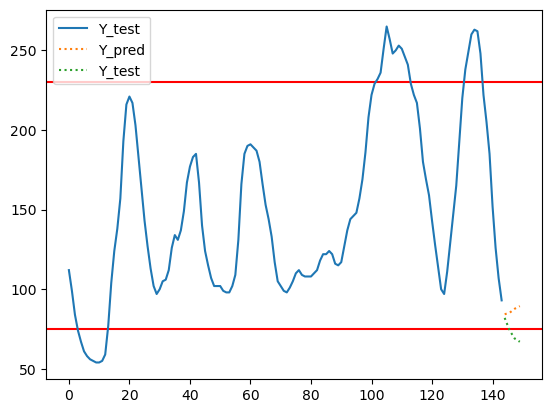

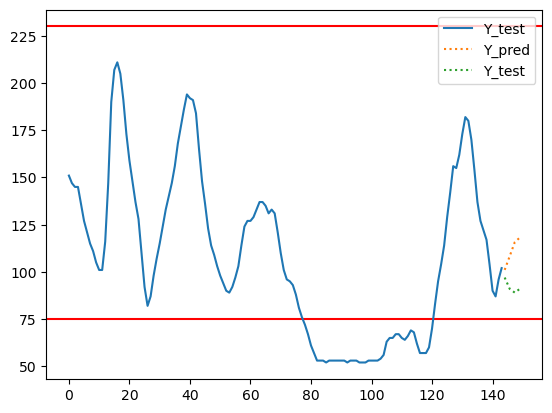

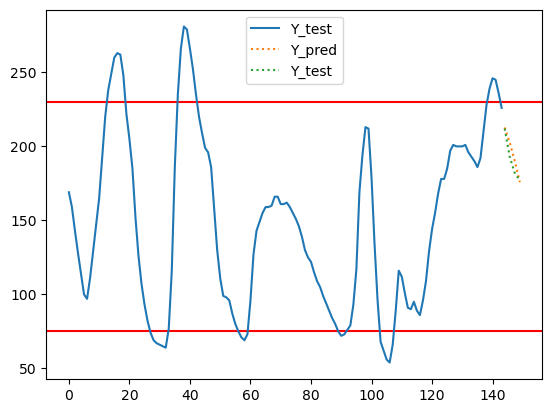

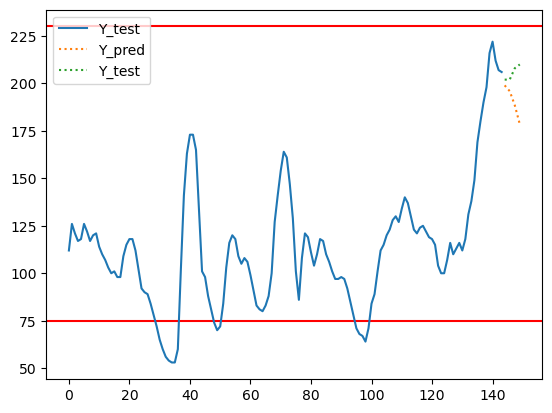

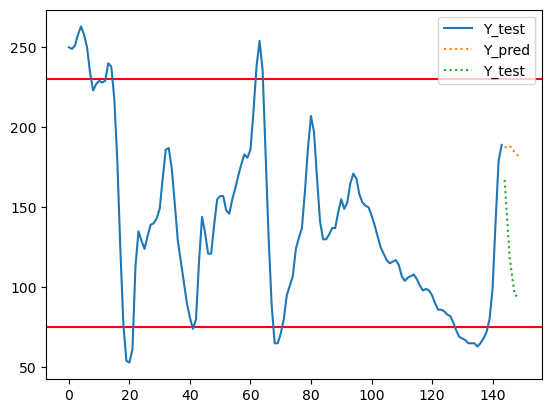

In [8]:
idx = 400
# random int 
idx = np.random.randint(0, X_test.shape[0])

for i in range(5):
    idx = np.random.randint(0, X_test.shape[0])
    plt.figure()
    #plt.plot(np.linspace(144,149, 4), Y_pred[100,0,:], label='Y_pred', linestyle='solid')
    # plt.plot(Y_test[100,:], label='Y_test', linestyle='dotted')
    plt.axhline(y=75, color='r', linestyle='-')
    plt.axhline(y=230, color='r', linestyle='-')
    plt.plot(X_test_denorm[idx,:], label='Y_test', linestyle='solid')
    plt.plot(np.linspace(144,149, 4), Y_pred[idx,:], label='Y_pred', linestyle='dotted')
    plt.plot(np.linspace(144,149, 4),Y_test_denorm[idx,:], label='Y_test', linestyle='dotted')
    plt.legend()
    plt.show()

In [9]:
print(Y_pred[299,:])

[ 92.861046  95.83234  100.70709  102.59747 ]


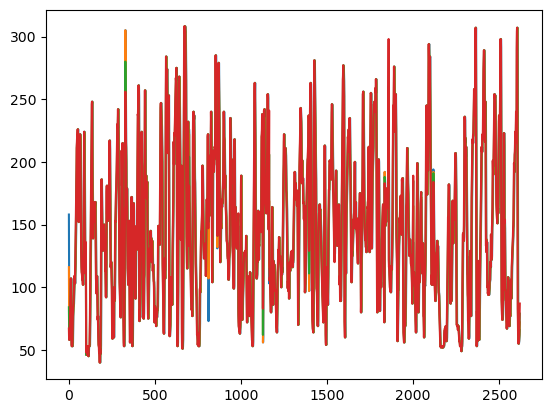

In [10]:
plt.figure()
plt.plot(Y_test[:,:])
plt.show()

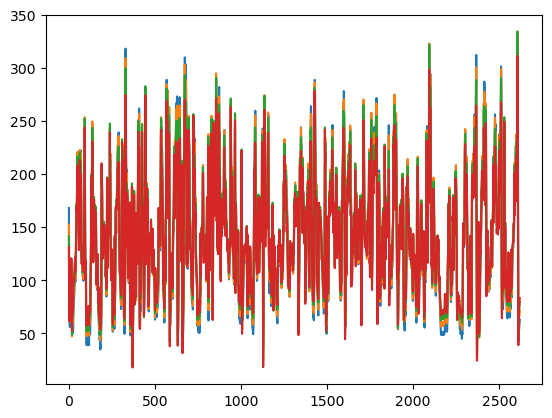

In [11]:
plt.figure()
plt.plot(Y_pred[:,:])
plt.show()

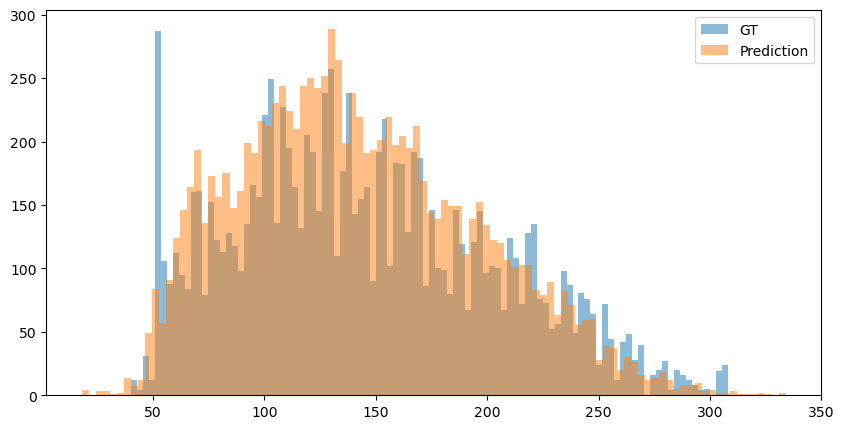

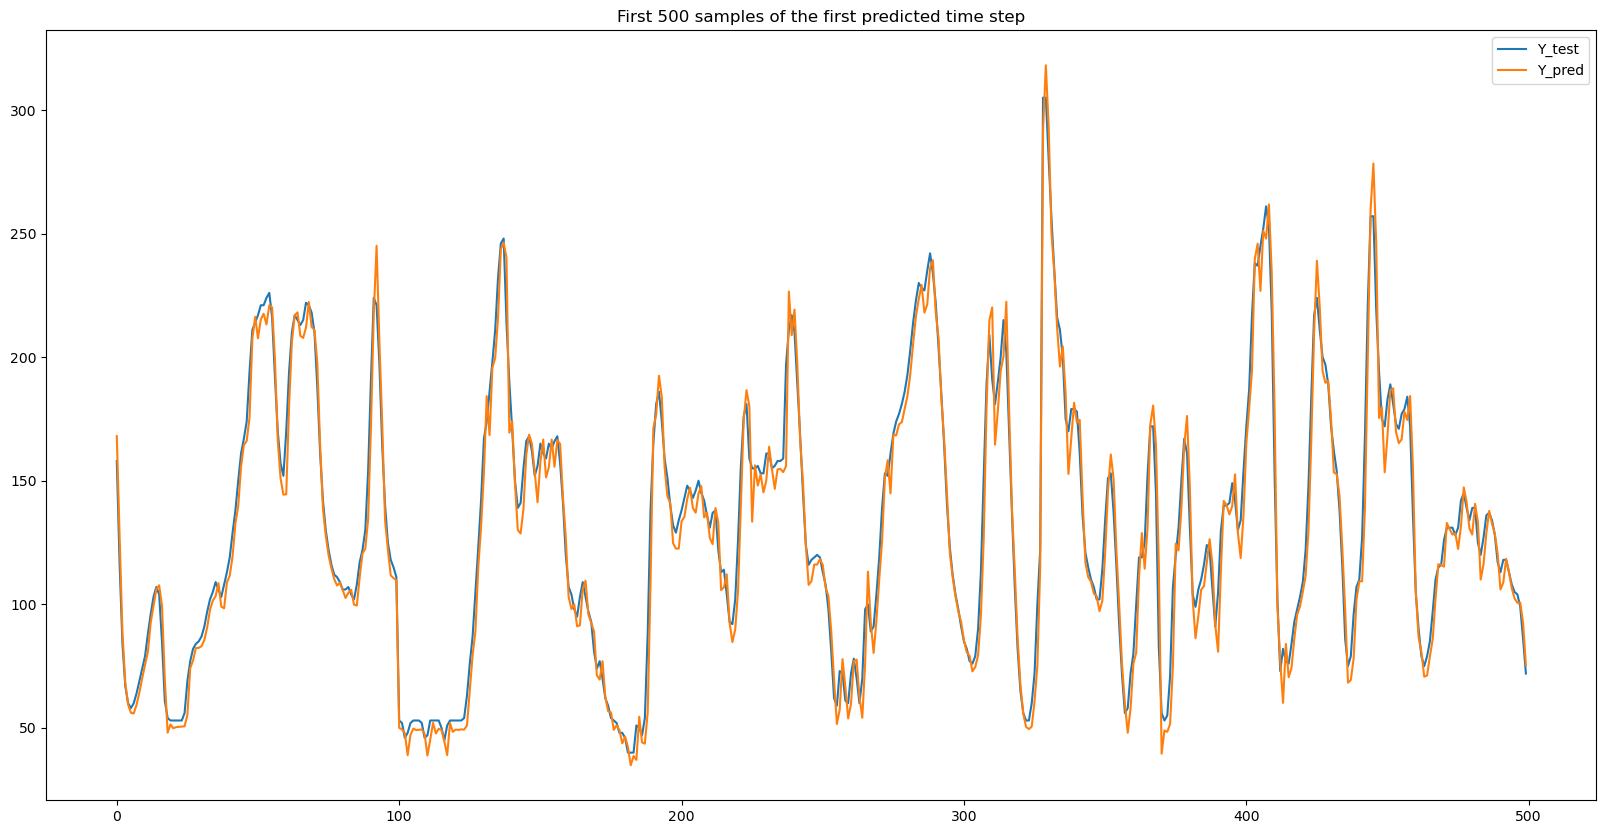

In [12]:
# Plot histograms of predictions and ground truth 
plt.figure(figsize = (10,5)) 
plt.hist(Y_test.flatten(), bins=100, alpha=0.5)
plt.hist(Y_pred.flatten(), bins=100, alpha=0.5)
plt.legend(['GT', 'Prediction'])
plt.show()

# Save a chunk of data to plot as an example of the first predicted time step
plt.figure(figsize = (20,10))
plt.plot(Y_test[0:500,0], label = 'Y_test')
plt.plot(Y_pred[0:500,0], label = 'Y_pred')
# Set title
plt.title('First 500 samples of the first predicted time step')
# Legend
plt.legend()
# Save the plot
plt.show()

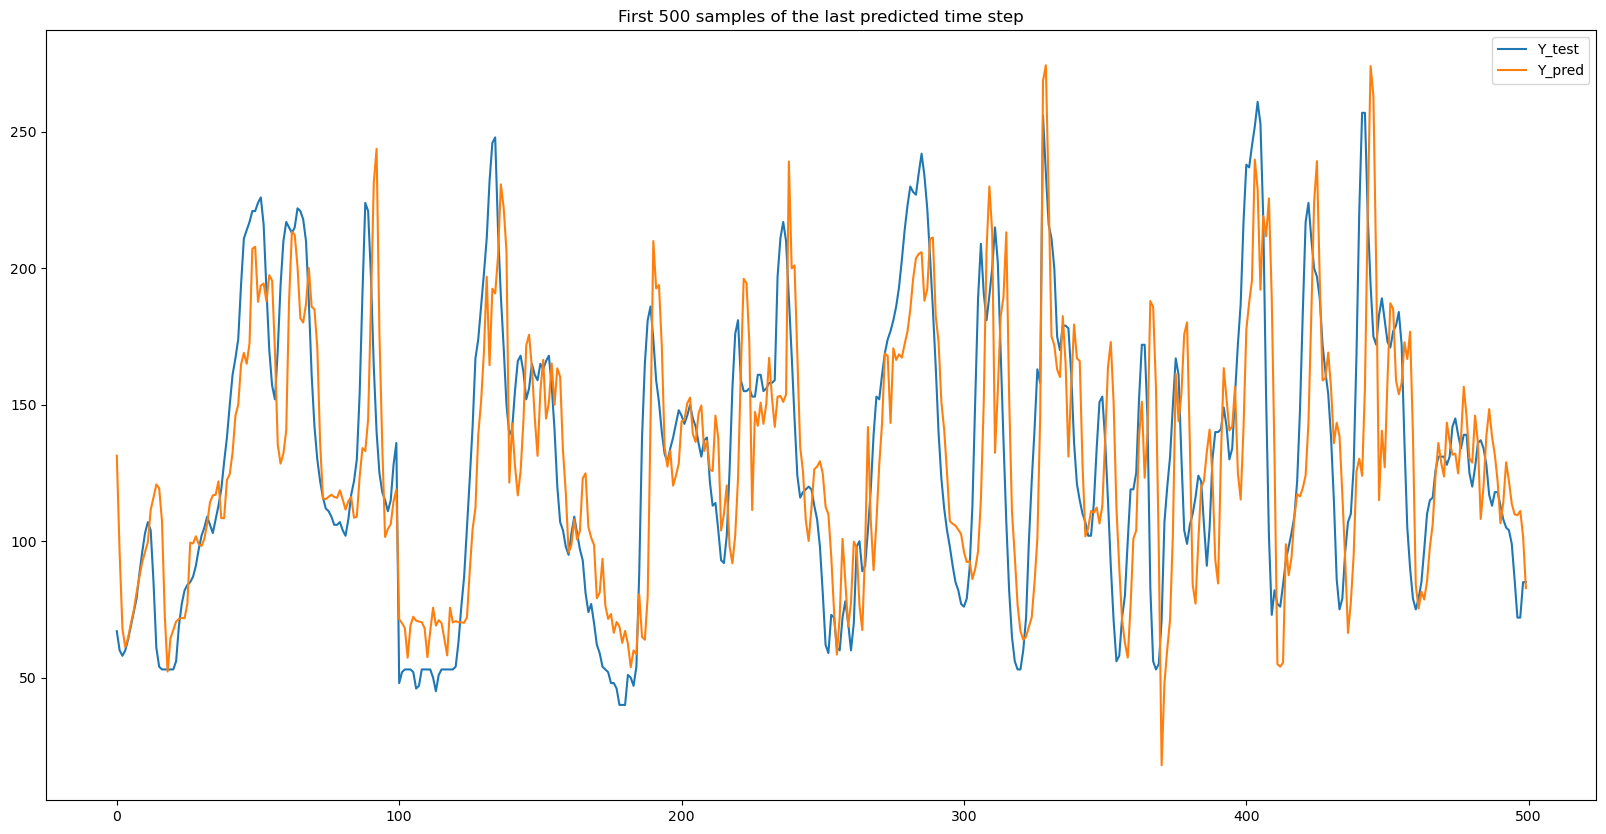

In [13]:
# Save a chunk of data to plot as an example of the first predicted time step
plt.figure(figsize = (20,10))
plt.plot(Y_test[0:500,round(4)-1], label = 'Y_test')
plt.plot(Y_pred[0:500,round(4)-1], label = 'Y_pred')
# Set title
plt.title('First 500 samples of the last predicted time step')
# Legend
plt.legend()
plt.show()

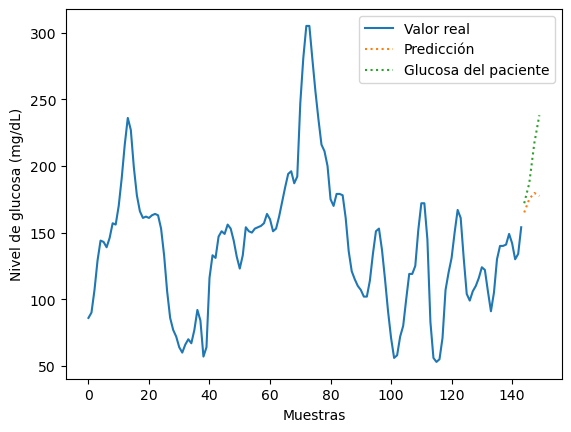

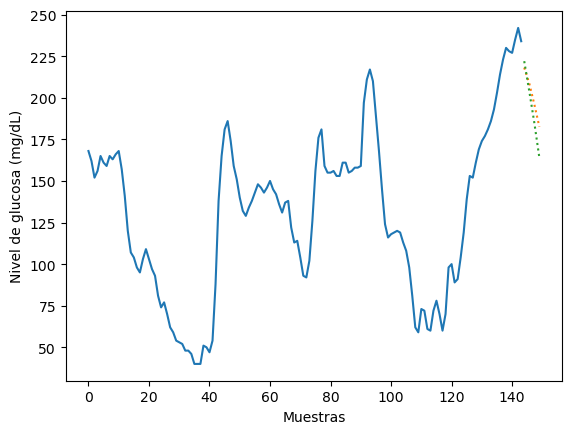

In [14]:
idx = 400

plt.figure()
#plt.plot(np.linspace(144,149, 4), Y_pred[100,0,:], label='Y_pred', linestyle='solid')
# plt.plot(Y_test[100,:], label='Y_test', linestyle='dotted')
plt.plot(X_test_denorm[idx,:], label='Valor real', linestyle='solid')
plt.plot(np.linspace(144,149, 4), Y_pred[idx,:], label='Predicción', linestyle='dotted')
plt.plot(np.linspace(144,149, 4),Y_test_denorm[idx,:], label='Glucosa del paciente', linestyle='dotted')
plt.ylabel("Nivel de glucosa (mg/dL)")
plt.xlabel("Muestras")
plt.legend()
plt.savefig('fig1.svg', dpi=300)
plt.show()


idx = 290 #200

plt.figure()
plt.plot(X_test_denorm[idx,:], label='Valor real', linestyle='solid')
plt.plot(np.linspace(144,149, 4), Y_pred[idx,:], label='Predicción', linestyle='dotted')
plt.plot(np.linspace(144,149, 4),Y_test_denorm[idx,:], label='Glucosa del paciente', linestyle='dotted')
plt.ylabel("Nivel de glucosa (mg/dL)")
plt.xlabel("Muestras")
#plt.legend()
plt.savefig('fig2.svg', dpi=300)
plt.show()

